Dataset : https://drive.google.com/drive/folders/1ZDVv9fsCaD3FdCp8RaoKKGFPfvmWbayd?usp=drive_link



This code implements a few-shot learning model for wheat disease classification using EfficientNet for feature extraction and an attention module for similarity learning, trained with cross-entropy loss and evaluated for accuracy.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [43]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Define Dataset Class
class WheatDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [4]:
# Load Dataset and Split into Train/Test
def load_data(data_dir, train_split=0.8):
    """
    Load dataset and split into train and test.
    :param data_dir: Path to dataset where folders represent classes.
    :param train_split: Ratio of training data (default: 80% train, 20% test).
    :return: Train and test datasets.
    """
    classes = sorted(os.listdir(data_dir))  # Get class names
    image_paths = []
    labels = []
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    for cls in classes:
        class_path = os.path.join(data_dir, cls)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory files
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image_paths.append(img_path)
            labels.append(class_to_idx[cls])

    # Shuffle the dataset
    dataset = list(zip(image_paths, labels))
    random.shuffle(dataset)
    image_paths, labels = zip(*dataset)

    # Split into train and test
    train_size = int(train_split * len(image_paths))
    train_images, test_images = image_paths[:train_size], image_paths[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]

    return train_images, train_labels, test_images, test_labels, class_to_idx


In [5]:
# Load Data
dataset_path = "./D3_Final"  # Update this with your dataset path
train_images, train_labels, test_images, test_labels, class_to_idx = load_data(dataset_path)

train_dataset = WheatDataset(train_images, train_labels, transform=transform)
test_dataset = WheatDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [6]:
# Feature Extractor (EfficientNet)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        self.efficient_net.classifier = nn.Identity()  # Remove last layer

    def forward(self, x):
        return self.efficient_net(x)


In [7]:
class AttentionModule(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        self.W1 = nn.Linear(feature_dim, feature_dim)
        self.W2 = nn.Linear(feature_dim, feature_dim)
        self.omega_x = nn.Parameter(torch.rand(feature_dim))
        self.omega_y = nn.Parameter(torch.rand(feature_dim))
        self.omega_xy = nn.Parameter(torch.rand(feature_dim))

    def forward(self, support, query):
        s = torch.relu(self.W1(support))
        q = torch.relu(self.W2(query))
        similarity = torch.sum(self.omega_x * s + self.omega_y * q + self.omega_xy * (s * q), dim=-1)

        # Ensure output matches EfficientNet feature size (1280)
        output = torch.relu(self.W1(support) + self.W2(query))
        return output  # Output must be (batch_size, 1280)


In [8]:
# Few-Shot Learning Network
class FewShotNetwork(nn.Module):
    def __init__(self, feature_dim=1280 , num_classes=4):
        super(FewShotNetwork, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.attention = AttentionModule(feature_dim)
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, support, query):
        support_features = self.feature_extractor(support)
        query_features = self.feature_extractor(query)
        similarity = self.attention(support_features, query_features)
        output = self.fc(similarity)
        return output


In [9]:
# Model Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FewShotNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



c:\Users\DELL\Documents\PFE\M3\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\Documents\PFE\M3\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Training Loop
def train_model(model, train_loader, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, images)  # Support and Query Set (same for now)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

train_model(model, train_loader)



Epoch [1/20], Loss: 0.4716
Epoch [2/20], Loss: 0.1601
Epoch [3/20], Loss: 0.1043
Epoch [4/20], Loss: 0.0698
Epoch [5/20], Loss: 0.0495
Epoch [6/20], Loss: 0.0439
Epoch [7/20], Loss: 0.0416
Epoch [8/20], Loss: 0.0317
Epoch [9/20], Loss: 0.0211
Epoch [10/20], Loss: 0.0205
Epoch [11/20], Loss: 0.0505
Epoch [12/20], Loss: 0.0202
Epoch [13/20], Loss: 0.0449
Epoch [14/20], Loss: 0.0350
Epoch [15/20], Loss: 0.0167
Epoch [16/20], Loss: 0.0363
Epoch [17/20], Loss: 0.0302
Epoch [18/20], Loss: 0.0170
Epoch [19/20], Loss: 0.0268
Epoch [20/20], Loss: 0.0240


In [14]:
# Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images, images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_model(model, test_loader)

Test Accuracy: 95.62%


Test Accuracy: 96.00%


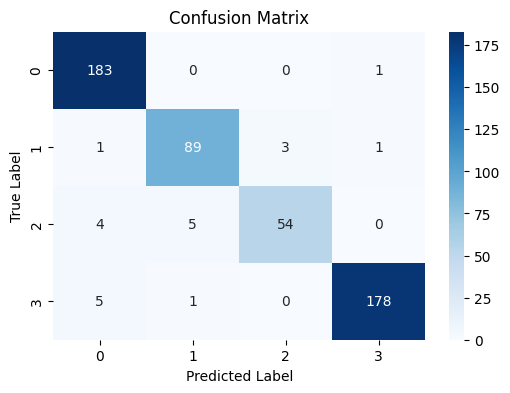

In [19]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Pass two inputs if required
            outputs = model(images, images)  # Check if this matches your model's expected inputs
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Compute and display confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call function
evaluate_model(model, test_loader)


In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Charger l'image
image_path = "test.jpg"
image = Image.open(image_path).convert("RGB")

# Définir les transformations (adaptées à votre modèle)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adapter à la taille d'entrée du modèle
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisation (ajuster selon votre modèle)
])

# Appliquer les transformations
image = transform(image)
image = image.unsqueeze(0)  # Ajouter une dimension batch

# Déplacer l'image vers l'appareil (GPU si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)

# Charger le modèle (s'assurer qu'il est en mode évaluation)
model.to(device)
model.eval()

# Prédiction
with torch.no_grad():
    output = model(image, image)  # ⚠️ Vérifiez si votre modèle prend deux entrées
    _, predicted = torch.max(output, 1)

# Liste des classes (modifier selon vos classes)
class_names = ["Brown-rust", "Pawdery_mildew","Stem-rust", "Yellow-rust"]
predicted_class = class_names[predicted.item()]

print(f"Classe prédite : {predicted_class}")


Classe prédite : Yellow-rust


In [ ]:
torch.save(model.state_dict(), "RustClassification.pth")
print("Modèle sauvegardé sous 'RustClassification.pth'")
# this model (RustClassification.pth) achaive 99,54% accuracy on the test set (yellow-rust, stem-rust,brown-rust)

Modèle sauvegardé sous 'RustClassification.pth'
